In [1]:
from utils_31_05 import *
import copy

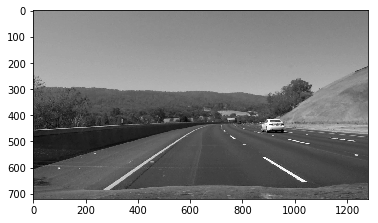

In [3]:
img = mpimg.imread('img/test3.jpg')
gray = rgb2gray(img)
gshow(gray)

C:\Users\ms\Desktop\lane-detection\python\utils_31_05.py:60: RuntimeWarning: invalid value encountered in float_scalars
  tan = rad2deg(math.atan(-gx[y,x] / gy[y,x]))
C:\Users\ms\Desktop\lane-detection\python\utils_31_05.py:60: RuntimeWarning: divide by zero encountered in float_scalars
  tan = rad2deg(math.atan(-gx[y,x] / gy[y,x]))


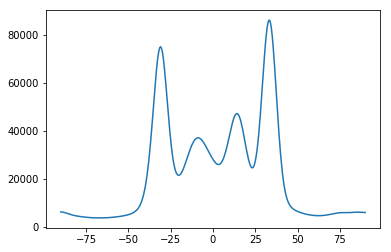

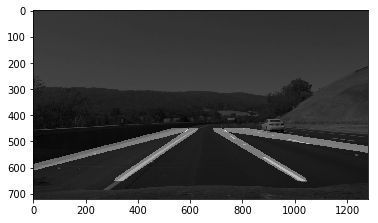

[-30.8356546   -8.77437326  14.28969359  33.84401114]


In [176]:
img_orig = mpimg.imread('img/test3.jpg')
img = img_orig[470:650,:]
#test = np.ones((100, 500))#img[470:650, 100:1200]
gray = rgb2gray(img_orig)
y, tan_arr, mag_arr = edf_comp(img)
edges, vm = get_edges_thetas(y, tan_arr, mag_arr)
gray_lines, lbrois, angs = draw_on_img(gray, edges, vm, mag_arr, 470, 650, thicc=24)
gshow(gray_lines)
#print(len(edges))
print(vm)

In [ ]:
im = plt.imshow()

In [127]:
total_lb = np.zeros_like(gray)
gx, gy = sobel(gray)
hyp = np.hypot(gx, gy)
for lb in lbrois:
    total_lb += lb
    #gshow(np.multiply(lb, hyp))
    
total_lb = total_lb>0
px_num = np.sum(total_lb)


filtered = np.multiply(hyp, total_lb)
mag_sum = np.sum(filtered)

mag_mean = mag_sum/px_num


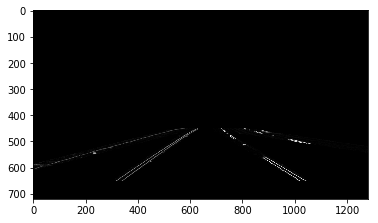

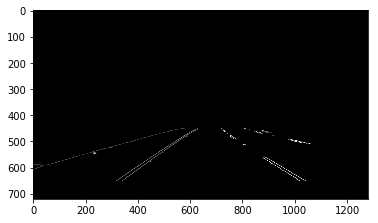

In [128]:
f = filtered > mag_mean
f2 = np.multiply(filtered, f)
gshow(filtered)
gshow(f2)

In [129]:
x = np.array([[1,0,0], [0,2,0], [1,1,0]])
print(x)
print(np.nonzero(x))
print(np.transpose(np.transpose(np.nonzero(x))))
print(x[np.nonzero(x)])

def lbroi_indexes(lbroi):
    indexes = np.transpose(np.nonzero(lbroi))
    return indexes

def lbroi_tan_mag(gx, gy, indexes):
    h, w = gx.shape
    
    tans = np.zeros((h,w))
    mags = np.zeros((h,w))
    for i in range(indexes.shape[0]):
        y = int(indexes[i, 0])
        x = int(indexes[i, 1])
        tan = rad2deg(math.atan(-gx[y,x] / gy[y,x]))
        tans[y,x] = tan
        mag = math.sqrt(gy[y,x]**2 + gx[y,x]**2)
        mags[y,x] = mag

    return tans, mags

[[1 0 0]
 [0 2 0]
 [1 1 0]]
(array([0, 1, 2, 2], dtype=int64), array([0, 1, 0, 1], dtype=int64))
[[0 1 2 2]
 [0 1 0 1]]
[1 2 1 1]


In [130]:
def lbroi_plot_vars(tans, mags, indexes):
    #print(tans.shape)
    tan_arr = np.zeros_like(tans)
    mag_arr = np.zeros_like(mags)
    
    mags = th_mag_arr(mags, indexes)
    
    #print(tan_arr.shape)
    h, w = tans.shape
    hist = {}
    xs = np.arange(-90, 91, 2)
    for x in xs:
        hist[x] = 0
    
    for i in range(indexes.shape[0]):
        #print(indexes[i].shape)
        #print(indexes.shape)
        y = int(indexes[i, 0])
        x = int(indexes[i, 1])
        #print(tans[y].shape)
        #print(tans[x].shape)
        #print(tans.shape)
        if (np.isnan(tans[y,x])):
            continue
        else:
            tan_arr[y,x] = tans[y,x]
            mag_arr[y,x] = mags[y,x]
            if (int(tans[y,x]) % 2 is 0):
                hist[int(tans[y,x])] += mags[y,x]
            else:
                hist[int(tans[y,x]) - 1] += mags[y,x]
    
    return hist, tan_arr, mag_arr

def th_mag_arr(mag_arr, indexes, th=0.5):
    mag_sum = np.sum(mag_arr)
    px_num = indexes.shape[0]
    mean = mag_sum/px_num
    
    th_mag_arr = np.multiply(mag_arr, mag_arr>mean)
    
    return th_mag_arr

def lbroi_one_edge_edf(img, lbroi, sigma=7, ret=True):
    indexes = lbroi_indexes(lbroi)
    gray_blur = pre(img)
    gx, gy = sobel(gray_blur)
    tans, mags = lbroi_tan_mag(gx, gy, indexes)
    hist, tan_arr, mag_arr = lbroi_plot_vars(tans, mags, indexes)
    x, y = edf_smooth(hist, sigma=sigma)
    #print(x.shape)
    #print(y.shape)
    plt.plot(x, y)
    plt.show()
    if ret:
        return y, tan_arr, mag_arr, indexes

In [131]:
def lbroi_get_maxima(y):
    x = np.linspace(-90, 90, 361)
    #maxm = argrelextrema(y, np.greater)
    global_max = x[np.argmax(y)]
    return global_max

In [169]:
'''y, tan_arr, mag_arr = lbroi_one_edge_edf(img_orig, lbrois[3])
print(tan_arr.shape)
glob = lbroi_get_maxima(y)
print(glob)
'''
def single_edge_image(tan_arr, mag_arr, alpha, indexes):
    h, w = tan_arr.shape
    single_edge_image = np.zeros_like(mag_arr)
    for i in range(indexes.shape[0]):
        y = indexes[i, 0]
        x = indexes[i, 1]
        if abs(tan_arr[y,x] - alpha) < 2.0:
            single_edge_image[y,x] = mag_arr[y,x]
                
    return single_edge_image

def get_new_angles_edges(img, lbrois):
    aeim = []
    for lb in lbrois:
        y, tan_arr, mag_arr, indexes = lbroi_one_edge_edf(img, lb)
        edge_angle = lbroi_get_maxima(y)
        edge = single_edge_image(tan_arr, mag_arr, edge_angle, indexes)
        aeim.append([edge_angle, edge, indexes, mag_arr])
        
    aeim.sort(key=itemgetter(0))
    
    return aeim



def hough_angles(aeim1):
    aeim = copy.deepcopy(aeim1)
    for i in range(len(aeim)):
        a = aeim[i][0]
        if a < 0:
            aeim[i][0] = -90 - a
        else:
            aeim[i][0] = 90 - a
    
    return aeim

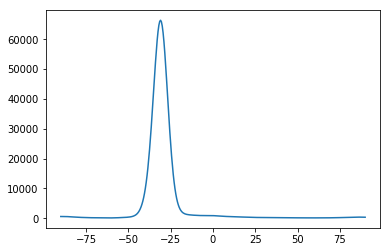

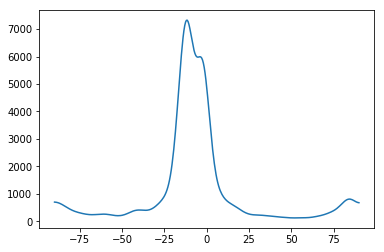

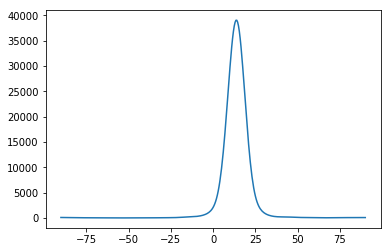

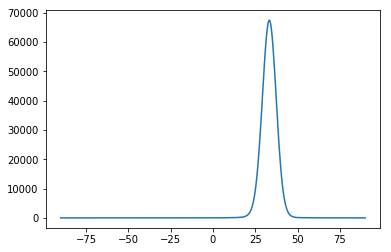

In [177]:
aeim = get_new_angles_edges(img_orig, lbrois)

-31.0


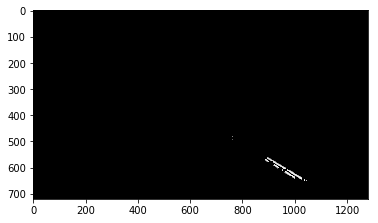

-11.5


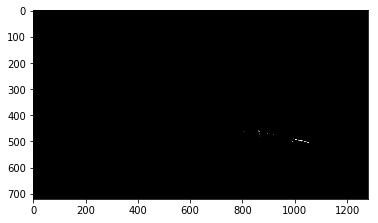

14.0


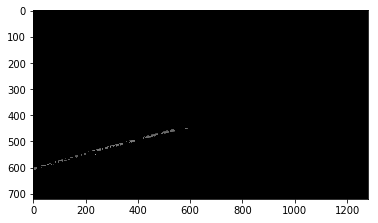

33.5


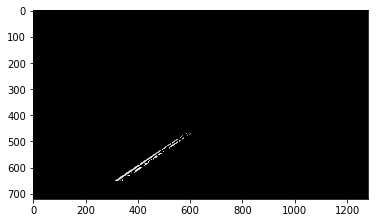

In [171]:
for i in range(len(angle_edge_index)):
    print(aeim[i][0])
    gshow(aeim[i][1])

In [172]:
def lbroi_weighted_hough(edge_img, theta, mag_arr, indexes):
    t = deg2rad(theta)
    h, w = edge_img.shape
    diag = int(math.ceil(math.sqrt(h**2 + w**2)))
    acc = np.zeros(2*diag+1)
    for i in range(indexes.shape[0]):
        y = int(indexes[i, 0])
        x = int(indexes[i, 1])
        if edge_img[y,x] > 0:
            rho = int((y * math.sin(t) + x * math.cos(t)) + diag)
            acc[rho] += mag_arr[y,x]
                
    return acc, diag, theta

EXTENSION = 20

def lbroi_line(rho, alpha, h=720, w=1280, thicc=5):
    line_im = np.zeros((h, w)).astype(np.uint8)
    p = []
    for x in range(w):
        y = int( -x / math.tan(alpha * (math.pi/180)) + (rho / (math.sin(alpha*(math.pi/180)))))
        if (y < h and y >= 0):
            p.append((x, y))
    
    p.sort(key=itemgetter(1))
    
    #print('orig', p[0], p[last])
    
    ps = (p[0], p[-1])
    #ps = calc_p((p[-1], p[0]))
    
    #print('new', ps)
    cv2.line(line_im, ps[0], ps[1], (255,255,255), thickness=thicc)
    return line_im[450:650,:]

In [173]:
def lbroi_draw_on_img(gray, aeim1, y1=470, y2=650, thicc=20):
    gray_lines = np.copy(gray)
    #h, w = (470,1280)
    aeim = hough_angles(aeim1)
    lbrois = []
    for i in range(len(aeim)):
        lbroi = np.zeros_like(gray)
        mag_arr = aeim[i][3]
        indexes = aeim[i][2]
        edge_im = aeim[i][1]
        angle = aeim[i][0]
        #gshow(edge_im)
        #print(i, 'angle:', angle)
        #gshow(mag_arr)
        #print(i, 'mag_arr.shape:', mag_arr.shape)
        acc, diag, theta = lbroi_weighted_hough(edge_im, angle, mag_arr, indexes)
        
        smooth_acc = gaussian_filter1d(acc, sigma=41)
        x = np.arange(0, 2*diag+1, 1)
        
        global_max = x[np.argmax(smooth_acc)]
        
        rho = global_max - diag
        
        line_img = lbroi_line(rho, angle, thicc=thicc)
        
        coors = np.zeros(4).astype(np.uint32)
        
        coors[0] = y1-EXTENSION
        coors[1] = y2
        coors[2] = 0 
        coors[3] = 1280
        
        #for g in range(4):
        #    coors[g] = int(coors[g])
        #    print(coors[g])
        #for j in range(4):
        #    print(coors[j])
        
        #print(lbroi.shape)
        #print(line_img.shape)
        #print(i, 'line_img: ')
        #gshow(line_img)
        
        lbroi[coors[0]:coors[1], coors[2]:coors[3]] += line_img
        lbrois.append(lbroi)
        gray_lines[coors[0]:coors[1], coors[2]:coors[3]] += line_img
    
    return gray_lines, lbrois

In [174]:
gray_lines, lbs = lbroi_draw_on_img(gray, aeim)

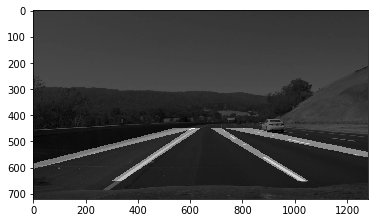

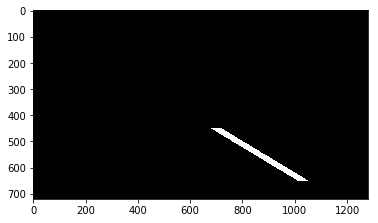

In [175]:
gshow(gray_lines)
gshow(lbs[0])

C:\Users\ms\Desktop\lane-detection\python\utils_31_05.py:183: RuntimeWarning: invalid value encountered in float_scalars
  tan = rad2deg(math.atan(-gx[y,x] / gy[y,x]))
C:\Users\ms\Desktop\lane-detection\python\utils_31_05.py:183: RuntimeWarning: divide by zero encountered in float_scalars
  tan = rad2deg(math.atan(-gx[y,x] / gy[y,x]))


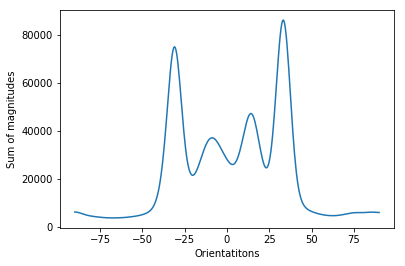

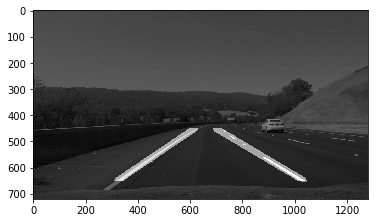

[-30.835654596100284, 33.844011142061277]


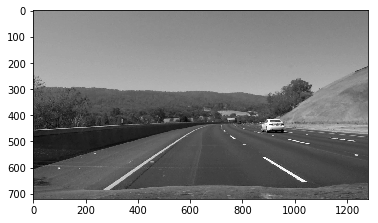

In [2]:
img_orig = mpimg.imread('img/test3.jpg')
img = img_orig[470:650,:]
#test = np.ones((100, 500))#img[470:650, 100:1200]
gray = rgb2gray(img_orig)
y, tan_arr, mag_arr = edf_comp(img, plott=True)
edges, vm = get_edges_thetas(y, tan_arr, mag_arr)
gray_lines, lbrois, angs = draw_on_img(gray, edges, vm, mag_arr, 470, 650, thicc=24)
gshow(gray_lines)
#print(len(edges))
print(vm)
gshow(gray)

In [32]:
k = np.array(l)

In [34]:
k.shape

(8853, 2)